#### 化学突触连接的 ML 模型，MSF研究

ref: W. Nicola, Rapid changes in synchronizability in conductance-based neuronal networks with conductance-based coupling, Chaos 34, 023123 (2024).

model: Morris–Lecar neuron model


In [1]:
import copy
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from numba import njit, prange
import pandas as pd
import os
os.environ["OMP_NUM_THREADS"] = "4"  # 将4替换为你希望使用的线程数
os.environ["OPENBLAS_NUM_THREADS"] = "4"

### 不对称情况msf的函数

In [2]:
@njit
def rk4_step(x, t, dt, f, *args):
    k1 = f(x, t, *args)
    k2 = f(x + (dt / 2.) * k1, t + (dt / 2.), *args)
    k3 = f(x + (dt / 2.) * k2, t + (dt / 2.), *args)
    k4 = f(x + dt * k3, t + dt, *args)
    return x + (dt / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)


@njit
def msf_mLCE_jit_complex(x0, f, jac, n_forward, n_compute, dt, gamma, *args):
    """
    计算gamma为复数情况的msf
    Parameters:
        x0 (numpy.ndarray)：初始条件。
        f（function）: ẋ = f(x, t) 或 x_(n 1) = f(x_n) 的函数 f。
        jac（function）: f 相对于 x 的雅可比行列式。
        n_forward (int): Number of steps before starting the mLCE computation.
        n_compute (int): Number of steps to compute the mLCE, can be adjusted using keep_evolution.
        dt（float）: 两个时间步之间的时间间隔。
        *args :  f 和 jac 需要修改的量
    """
    t = 0
    x = x0
    dim = len(x0)
    # 初始化
    for _ in range(n_forward):
        x = rk4_step(x, t, dt, f, *args)
        t += dt

    # Compute the mLCE
    mLCE = 0.
    W = np.random.rand(dim) + 1j * np.random.rand(dim) # 随机生成一个与系统状态向量维度相同的向量，这里是复数形式
    W = W / np.linalg.norm(W)

    for _ in range(n_compute):
        # w = system.next_LTM(w)
        jacobian = jac(x, t, gamma, *args)
        jacobian = jacobian.astype(np.complex128) # 将得到的雅可比矩阵变成复数形式

        k1 = jacobian @ W
        k2 = jacobian @ (W + (dt / 2.) * k1)
        k3 = jacobian @ (W + (dt / 2.) * k2)
        k4 = jacobian @ (W + dt * k3)
        W = W + (dt / 6.) * (k1 + 2 * k2 + 2 * k3 + k4)

        # system.forward(1, False)
        x = rk4_step(x, t, dt, f, *args)
        t += dt

        mLCE += np.log(np.linalg.norm(W))
        W = W / np.linalg.norm(W)

    mLCE = mLCE / (n_compute * dt)

    return mLCE


## ML模型

### 需要改变的参数

In [3]:
# 外加变量和参数变量
I = 50 # classI 50, classII 115 pA
phi = 0.067 # classI 0.067, classII 0.04 mV
V3 = 12 # classI 12, classII 2 mV
V4 = 17.4 # classI 17.4, classII 30

g = 2.1 # 这里后面要改成可以随输入变化
E = 30 # 同上

### 同步解

In [4]:
@njit
def f(x, t): # g, E, --需要修改的变量
    res = np.zeros_like(x)

    # 参数常量
    C = 20 # pF
    g_L = 2 # nS
    g_K = 8 # nS 
    g_Ca = 4 # nS
    E_L = -60 # mV
    E_K = -84
    E_Ca = 120
    V1 = -1.2 # mV
    V2 = 18
    a_r = 1.1 # ms-1
    a_d = 0.19 # ms-1
    K_p = 5 # mV
    V_T = 2 # mV
    # 输出函数变量
    # 根据公式计算 m_infty 和 n_infty
    m_infty = 0.5 * (1 + np.tanh((x[0] - V1) / V2))
    n_infty = 0.5 * (1 + np.tanh((x[0] - V3) / V4))
    # 根据公式计算 tau_n
    tau_n = 1 / np.cosh((x[0] - V3) / (2 * V4))
    # 根据公式计算T
    T = 1 / (1 + np.exp(-(x[0] - V_T)/K_p))
    # 更新 res
    res[0] = (I - g_L * (x[0] - E_L) - g_K * x[1] * (x[0] - E_K) - g_Ca * m_infty * (x[0] - E_Ca) - g * x[2] * (x[0] - E)) / C # V
    res[1] = phi * ((n_infty - x[1]) / tau_n) # n
    res[2] = a_r * T * (1 - x[2]) - x[2] * a_d # r
    return res

### 雅可比矩阵

In [5]:
@njit
def jac(x, t, gamma):
    res = np.zeros((x.shape[0], x.shape[0]), dtype=np.complex128) # 之前出现float报错是因为res变量默认是float型，现在规定为复数**

    # 参数常量
    C = 20 # pF
    g_L = 2 # nS
    g_K = 8 # nS 
    g_Ca = 4 # nS
    E_L = -60 # mV
    E_K = -84
    E_Ca = 120
    V1 = -1.2 # mV
    V2 = 18
    # E = -60
    a_r = 1.1 # ms-1
    a_d = 0.19 # ms-1
    V_T = 2 # mV
    K_p = 5 # mV

    # 根据公式计算 m_infty 和 n_infty 
    m_infty = 0.5 * (1 + np.tanh((x[0] - V1) / V2))
    n_infty = 0.5 * (1 + np.tanh((x[0] - V3) / V4))
    # 根据公式计算 tau_n
    tau_n = 1 / np.cosh((x[0] - V3) / (2 * V4))
    # 根据公式计算T
    T = 1 / (1 + np.exp( - (x[0] - V_T) / K_p))  

    d_minf_dV = 0.5 * (1 / V2) * (1 - (np.tanh((x[0] - V1) / V2))**2) # m_infty对V的导
    d_ninf_dV = 0.5 * (1 / V4) * (1 - (np.tanh((x[0] - V3) / V4))**2) # n_infty对V的导
    d_tau_n_dV = -1 / (2 * V4) * np.sinh((x[0] - V3) / (2 * V4)) /  (np.cosh((x[0] - V3) / (2 * V4)))**2
    d_T_dV = (1 / K_p) * np.exp(-(x[0] - V_T) / K_p) / ((1 + np.exp(-(x[0] - V_T) / K_p))**2)

    res[0, 0] = (-g_L - g_K*x[1] - g_Ca*m_infty - g_Ca*(x[0]-E_Ca)*d_minf_dV - g * x[2]) / C
    res[0, 1] = (-g_K * (x[0] - E_K)) / C
    res[0, 2] = (-g * gamma * (x[0] - E)) / C #不要忘记乘上gamma *这里gamma是耦合L矩阵的特征值，gamma外的其他部分,是节点变量的内连矩阵在s处的jac
    res[1, 0] = phi * (d_ninf_dV / tau_n - (n_infty - x[1]) * d_tau_n_dV / tau_n**2)
    res[1, 1] = -phi / tau_n
    res[1, 2] = 0
    res[2, 0] = a_r * d_T_dV * (1 - x[2])
    res[2, 1] = 0
    res[2, 2] = -a_r * T - a_d

    return res    

### msf计算

In [6]:
x0 = np.array([-60, 0.5, 0.5])
t0 = 0.
dt = 1e-2
T_init = int(5e4)
T_cal = int(1e5)

In [7]:
a_values = np.linspace(-1, 1, 50)
b_values = np.linspace(-1, 1, 50)

@njit(parallel=True)
def parallel_msf_mLCE(a_values, b_values, x0, f, jac, T_init, T_cal, dt, *args):
    n1 = len(a_values)
    n2 = len(b_values)
    mlce_matrix = np.zeros((n1, n2))
    for i in prange(n2):
        for j in prange(n1):
            gamma = a_values[i] + b_values[j] * 1j
            mlce_matrix[i, j] = msf_mLCE_jit_complex(x0, f, jac, T_init, T_cal, dt, gamma)   

    return mlce_matrix

In [8]:
mlce_matrix = parallel_msf_mLCE(a_values, b_values, x0, f, jac, T_init, T_cal, dt)

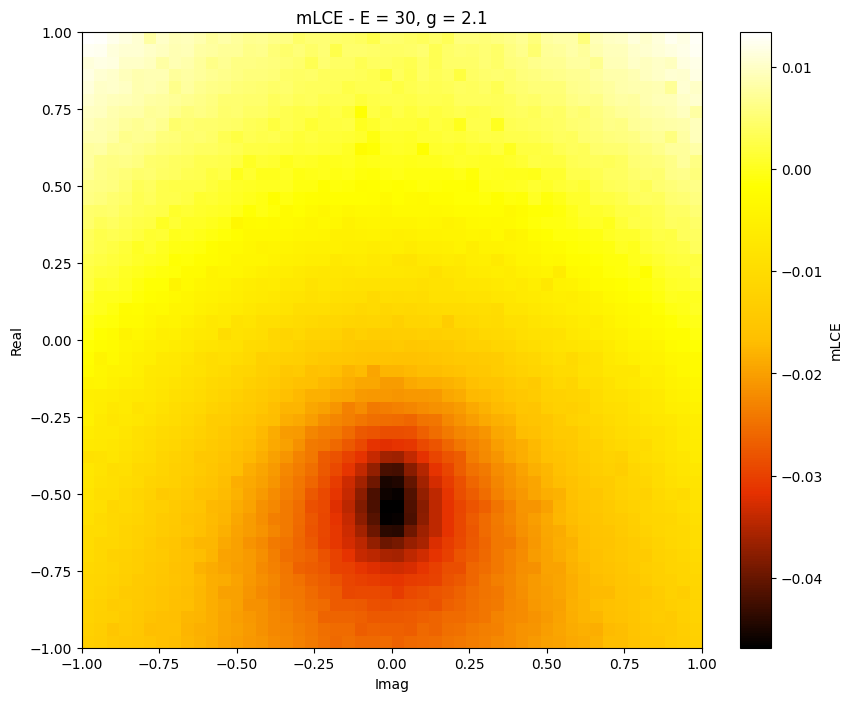

In [9]:
colors = [(0, 0, 0), (0.9, 0.19, 0), (1, 0.75, 0), (1, 1, 0), (1, 1, 1)]
cmap_custom = LinearSegmentedColormap.from_list('custom_cmap', colors)

plt.figure(figsize=(10, 8))
plt.imshow(mlce_matrix, extent=[-1, 1, -1, 1], origin='lower', aspect='auto', cmap=cmap_custom)
plt.colorbar(label='mLCE')
plt.ylabel('Real')
plt.xlabel('Imag')
# plt.title('mLCE')
plt.title(f'mLCE - E = {E}, g = {g}')
plt.show()